# Analysing the Semantic Change of Synonymous Pairs

In [1]:
import pickle
from tqdm import tqdm
import os

import scipy.sparse as sp
import scipy.stats as stats
import numpy as np
import pandas as pd

from mangoes.base import create_representation, CountBasedRepresentation
from mangoes.weighting import ShiftedPPMI
from mangoes.vocabulary import Vocabulary

from scipy.spatial.distance import jensenshannon,cosine
from sklearn.preprocessing import normalize
from scipy.stats import describe
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

/home/bastien/miniconda3/envs/synonyms/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_repr(repr_mode,decade,pos,alpha=0.75,k=1,wl=None,cl=None):
    L_mat = sp.load_npz(MATRIX_FOLDER+f'cooc-matrix_{decade}_{pos}_L.npz')
    R_mat = sp.load_npz(MATRIX_FOLDER+f'cooc-matrix_{decade}_{pos}_R.npz')

    if repr_mode.lower() == 'doubnorm':
        return normalize(normalize(sp.hstack([L_mat,R_mat]), axis=0,norm='l1'), axis=1,norm='l1').toarray()
    if repr_mode.lower() == 'sppmi':
        matrix = L_mat + R_mat
        matrix = CountBasedRepresentation(Vocabulary(wl), Vocabulary(cl), matrix)
        matrix = create_representation(matrix, weighting=ShiftedPPMI(alpha=alpha,shift=k))
        matrix.save('./temp/')
        with np.load('./temp/matrix.npz') as loaded:
            matrix = csr_matrix((loaded['data'], loaded['indices'], loaded['indptr']), shape=loaded['shape'])
        return normalize(matrix, axis=1,norm='l2').toarray()
    raise ValueError('Unkown representation mode. Use "sppmi" or "doubNorm".')
    

In [3]:
pos = 'A'

repr_mode = 'sppmi'
alpha = 0.75
k = 1

distance = 'cosine'
logbase = 2
suffix = repr_mode + '_' + distance


MATRIX_FOLDER = '/home/bastien/lscd/cooc_matrices_GNgrams_V2/'
SEMCHANGE_FOLDER = f'./semantic_change_measures/{suffix}/'
NEIGHBORS_FOLDER = f'./nearest_neighbors/{suffix}/'

DECADES = list(range(1890,2000,10))

In [4]:
with open(f'./words/{suffix}/fernald_{pos}_AVG.pickle','rb') as f:
    syn_pairs_avg = pickle.load(f)

In [5]:
if pos.lower() in ['a','adj','adjective']:
    pos = 'A'
    with open('./words/adjs_list.pickle','rb') as f:
        word_list = pickle.load(f)
elif pos.lower() in ['n','noun']:
    pos = 'N'
    with open('./words/nouns_list.pickle','rb') as f:
        word_list = pickle.load(f)
elif pos.lower() in ['v','verb']:
    pos = 'V'
    with open('./words/verbs_list.pickle','rb') as f:
        word_list = pickle.load(f)
else:
    raise ValueError('Invalid POS tag value : ' + pos)

word2ind = {word : i for i,word in enumerate(word_list)}
semchanges = pd.read_csv(SEMCHANGE_FOLDER+pos+'.csv',sep='\t',index_col='words')

with open('./words/contexts_list.txt','r',encoding='utf-8') as f:
    contexts = f.read().split('\n')
contexts = [context for context in contexts if context]

In [10]:
if distance.lower() == 'jsd':
    def JSD(arr1,arr2,base=logbase):
        '''
        Jensen-Shannon Divergence between two probability distributions. Square of the JS distance.
        '''
        return jensenshannon(arr1,arr2,base=base)**2
    dist = JSD
    distance_name = 'jsd_base'+str(logbase)

elif distance.lower() == 'cosine':
    dist = cosine
    distance_name = 'cosine'
else:
    raise ValueError('Unknown distance. Use "jsd" or "cosine".')

## Computing divergence in synonyms pairs

In [7]:
matrix_1890 = get_repr(repr_mode,1890,pos,alpha=alpha,k=k,wl=word_list,cl=contexts)

matrix_1990 = get_repr(repr_mode,1990,pos,alpha=alpha,k=k,wl=word_list,cl=contexts)

distances_1890 = []
distances_1990 = []
for i,(s1,s2) in tqdm(enumerate(syn_pairs_avg), desc="Synonyms", total=len(syn_pairs_avg)):
    ind1 = word2ind[s1]
    ind2 = word2ind[s2]
    v10, v20 = matrix_1890[[ind1,ind2]]
    distances_1890.append(dist( v10 , v20))
    v11, v21 = matrix_1990[[ind1,ind2]]
    distances_1990.append(dist( v11 , v21))
distances_1890 = np.array(distances_1890)
distances_1990 = np.array(distances_1990)
describe(distances_1890)

Synonyms: 100%|██████████| 1096/1096 [00:00<00:00, 4341.03it/s]


DescribeResult(nobs=1096, minmax=(0.21817140570369875, 1.0), mean=0.7820938977298749, variance=0.028683560359193668, skewness=-0.8002892848361307, kurtosis=-0.15845765287749547)

In [8]:
describe(distances_1990)

DescribeResult(nobs=1096, minmax=(0.19749085688314894, 1.0), mean=0.7890777183192967, variance=0.028596165814507284, skewness=-0.93182771121584, kurtosis=0.12810203939604925)

In [9]:
describe(distances_1990-distances_1890)

DescribeResult(nobs=1096, minmax=(-0.5286403829453372, 0.5261264083431275), mean=0.006983820589421867, variance=0.008052568393767272, skewness=0.07263581396921924, kurtosis=3.418268136937562)

## Analysing the divergence between pairs

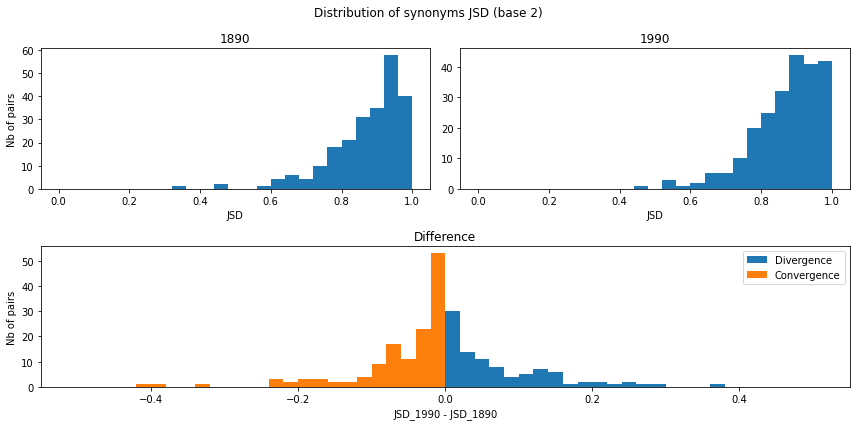

In [9]:
bin_count = 25

fig = plt.figure(figsize=(12,6))
fig.set_facecolor('white')
ax = fig.subplot_mosaic([['1890','1990'],['D','D']])
ax['1890'].hist(distances_1890, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1890'].set_title('1890')
ax['1990'].hist(distances_1990, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1990'].set_title('1990')
ax['D'].hist(distances_1990-distances_1890, bins=(np.arange(bin_count+1)*(0.5/bin_count)), label = 'Divergence')
ax['D'].hist(distances_1990-distances_1890, bins=(np.arange(bin_count+1)*(0.5/bin_count)-0.5), label = 'Convergence')
ax['D'].set_title('Difference')
ax['D'].legend()
ax['1890'].set_ylabel('Nb of pairs')
ax['1890'].set_xlabel('JSD')
ax['1990'].set_xlabel('JSD')
ax['D'].set_ylabel('Nb of pairs')
ax['D'].set_xlabel('JSD_1990 - JSD_1890')
fig.suptitle(f'Distribution of synonyms {distance}')
fig.tight_layout()
fig.savefig('./img/'+distance_name+'_'+pos+'_NEWCRIT_threshold.png',transparent=False,dpi=100)
plt.show()

In [10]:
rng = np.random.default_rng(0)
n_samples = 50000
samples = rng.choice(len(word_list),size=2*n_samples).reshape( (n_samples,2) )
random_distances_1890 = np.empty(n_samples)
random_distances_1990 = np.empty(n_samples)
for index, (ind1,ind2) in tqdm( enumerate(samples) ):
    v10, v20 = matrix_1890[[ind1,ind2]]
    random_distances_1890[index] = JSD( v10 , v20 , base=base)
    v11, v21 = matrix_1990[[ind1,ind2]]
    random_distances_1990[index] = JSD( v11 , v21 , base=base)

50000it [00:31, 1599.41it/s]


In [14]:
describe(random_distances_1890)

DescribeResult(nobs=50000, minmax=(0.0, 0.9999904089281192), mean=0.9549033190865435, variance=0.0026690511918790196, skewness=-3.0872977450533634, kurtosis=23.88278834928731)

In [15]:
describe(distances_1890)

DescribeResult(nobs=231, minmax=(0.329172576800266, 0.9941396226108425), mean=0.8732773815691794, variance=0.010977021272456686, skewness=-1.7243236165284668, kurtosis=4.275877230798921)

In [13]:
stats.ttest_ind(distances_1990-distances_1890,random_distances_1990-random_distances_1890,alternative='two-sided')

Ttest_indResult(statistic=4.040294578361372, pvalue=5.346344935302302e-05)

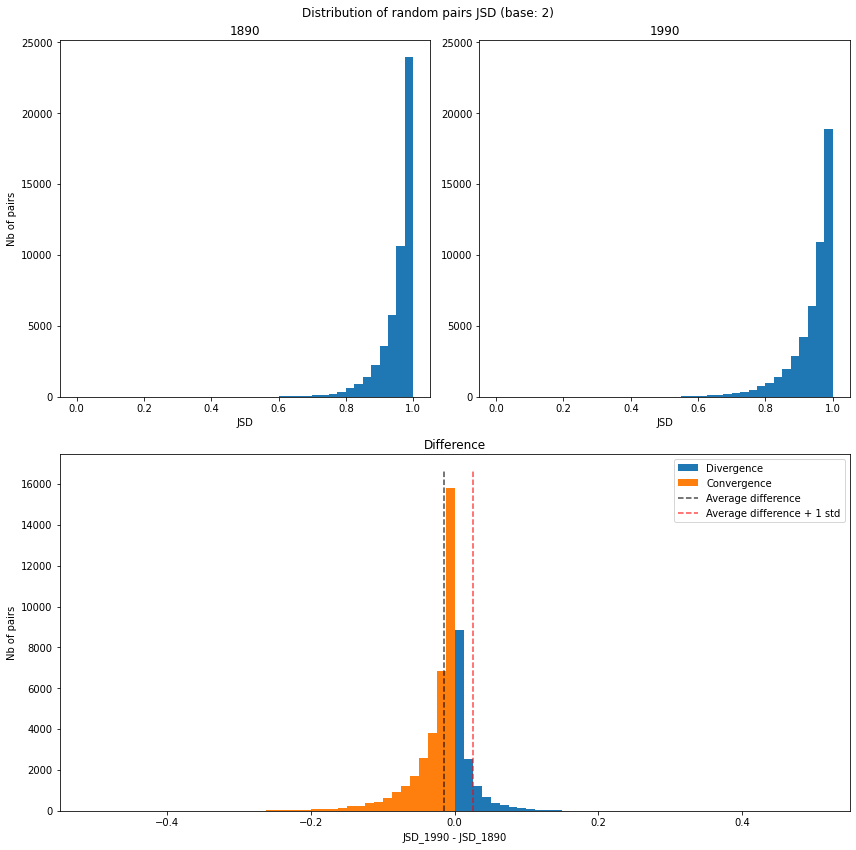

In [16]:
distance_name = f'JSD (base {base})'
bin_count = 40

fig = plt.figure(figsize=(12,12))
fig.set_facecolor('white')
ax = fig.subplot_mosaic([['1890','1990'],['D','D']])
ax['1890'].hist(random_distances_1890, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1890'].set_title('1890')
ax['1990'].hist(random_distances_1990, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1990'].set_title('1990')
ax['1990'].set_ylim( ax['1890'].get_ylim() ) 
diff_random = random_distances_1990-random_distances_1890
ax['D'].hist(diff_random, bins=(np.arange(bin_count+1)*(0.5/bin_count)), label = 'Divergence')
ax['D'].hist(diff_random, bins=(np.arange(bin_count+1)*(0.5/bin_count)-0.5), label = 'Convergence')
ymin, ymax = ax['D'].get_ylim()
ax['D'].vlines(diff_random.mean(),ymin=ymin, ymax=ymax ,label='Average difference',colors='black',linestyles='--',alpha=0.7)
ax['D'].vlines(diff_random.mean()+diff_random.std(), ymin=ymin, ymax=ymax,label='Average difference + 1 std',colors='red',linestyles='--',alpha = 0.7)
ax['D'].set_title('Difference')
ax['D'].legend()
ax['1890'].set_ylabel('Nb of pairs')
ax['1890'].set_xlabel('JSD')
ax['1990'].set_xlabel('JSD')
ax['D'].set_ylabel('Nb of pairs')
ax['D'].set_xlabel('JSD_1990 - JSD_1890')
fig.suptitle(f'Distribution of random pairs {distance_name}')
fig.tight_layout()
fig.savefig('./img/'+distance_name+'_random_'+pos+'.png',transparent=False,dpi=100)
plt.show()

In [97]:
diverge_prop_random = (random_distances_1990-random_distances_1890 > 0).sum()/n_samples
diverge_prop_syns = (distances_1990-distances_1890 > 0).sum()/len(syn_pairs_avg)

print(f'General divergence rate : {diverge_prop_random.round(3)*100}%')
print(f'Synonyms divergence rate : {diverge_prop_syns.round(3)*100}%')

General divergence rate : 22.6%
Synonyms divergence rate : 65.2%


In [18]:
stats.ttest_ind(random_distances_1990-random_distances_1890 , distances_1990 - distances_1890, alternative='two-sided')

Ttest_indResult(statistic=-4.040294578361372, pvalue=5.346344935302302e-05)

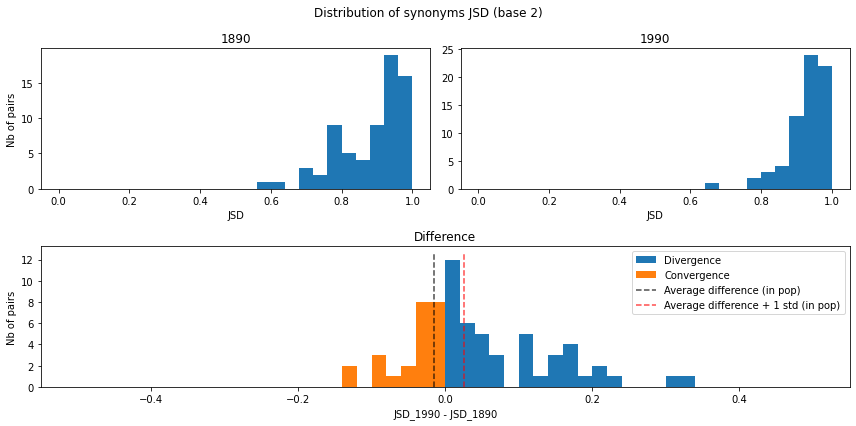

In [98]:
distance_name = f'JSD (base {base})'
bin_count = 25

fig = plt.figure(figsize=(12,6))
fig.set_facecolor('white')
ax = fig.subplot_mosaic([['1890','1990'],['D','D']])
ax['1890'].hist(distances_1890, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1890'].set_title('1890')
ax['1990'].hist(distances_1990, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1990'].set_title('1990')
ax['D'].hist(distances_1990-distances_1890, bins=(np.arange(bin_count+1)*(0.5/bin_count)), label = 'Divergence')
ax['D'].hist(distances_1990-distances_1890, bins=(np.arange(bin_count+1)*(0.5/bin_count)-0.5), label = 'Convergence')
ymin, ymax = ax['D'].get_ylim()
ax['D'].vlines(diff_random.mean(),ymin=ymin, ymax=ymax ,label='Average difference (in pop)',colors='black',linestyles='--',alpha=0.7)
ax['D'].vlines(diff_random.mean()+diff_random.std(), ymin=ymin, ymax=ymax,label='Average difference + 1 std (in pop)',colors='red',linestyles='--',alpha = 0.7)
ax['D'].set_title('Difference')
ax['D'].legend()
ax['1890'].set_ylabel('Nb of pairs')
ax['1890'].set_xlabel('JSD')
ax['1990'].set_xlabel('JSD')
ax['D'].set_ylabel('Nb of pairs')
ax['D'].set_xlabel('JSD_1990 - JSD_1890')
fig.suptitle(f'Distribution of synonyms {distance_name}')
fig.tight_layout()
fig.savefig('./img/'+distance_name+'_'+pos+'_NEWCRIT_thresholds.png',transparent=False,dpi=100)
plt.show()

Third size :  23


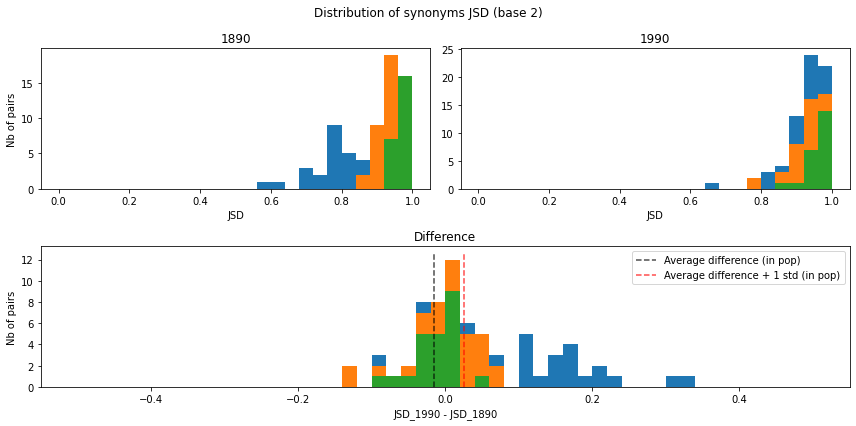

In [99]:
distance_name = f'JSD (base {base})'
bin_count = 25

third = len(distances_1890)//3
print('Third size : ',third)
sorted_1890_indexes = np.argsort(distances_1890)
close_grp = list(sorted_1890_indexes[:third])
mid_grp = list(sorted_1890_indexes[third:2*third])
far_grp = list(sorted_1890_indexes[2*third:])


fig = plt.figure(figsize=(12,6))
fig.set_facecolor('white')
ax = fig.subplot_mosaic([['1890','1990'],['D','D']])
ax['1890'].hist(distances_1890, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1890'].hist(distances_1890[mid_grp+far_grp], bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1890'].hist(distances_1890[far_grp], bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1890'].set_title('1890')
ax['1990'].hist(distances_1990, bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1990'].hist(distances_1990[mid_grp+far_grp], bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1990'].hist(distances_1990[far_grp], bins=(np.arange(bin_count+1)*(1/bin_count)) )
ax['1990'].set_title('1990')
ax['D'].hist( (distances_1990-distances_1890), bins=(np.arange(2*bin_count+1)*(0.5/bin_count))-0.5 )
ax['D'].hist( (distances_1990-distances_1890)[mid_grp+far_grp], bins=(np.arange(2*bin_count+1)*(0.5/bin_count))-0.5 )
ax['D'].hist( (distances_1990-distances_1890)[far_grp], bins=(np.arange(2*bin_count+1)*(0.5/bin_count))-0.5 )
ymin, ymax = ax['D'].get_ylim()
ax['D'].vlines(diff_random.mean(),ymin=ymin, ymax=ymax ,label='Average difference (in pop)',colors='black',linestyles='--',alpha=0.7)
ax['D'].vlines(diff_random.mean()+diff_random.std(), ymin=ymin, ymax=ymax,label='Average difference + 1 std (in pop)',colors='red',linestyles='--',alpha = 0.7)
ax['D'].set_title('Difference')
ax['D'].legend()
ax['1890'].set_ylabel('Nb of pairs')
ax['1890'].set_xlabel('JSD')
ax['1990'].set_xlabel('JSD')
ax['D'].set_ylabel('Nb of pairs')
ax['D'].set_xlabel('JSD_1990 - JSD_1890')
fig.suptitle(f'Distribution of synonyms {distance_name}')
fig.tight_layout()
fig.savefig('./img/'+distance_name+'_'+pos+'_NEWCRIT_thresholds_groups.png',transparent=False,dpi=100)
plt.show()

## Analysing the semantic change of words

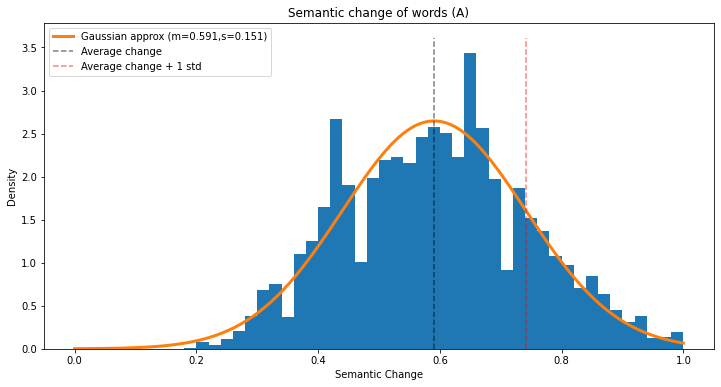

In [58]:
bin_count = 50

sc_series = semchanges['1990']

fig = plt.figure(figsize=(12,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.hist(sc_series, bins=(np.arange(bin_count+1)*(1/bin_count)) ,density=True)
ax.set_title(f'Semantic change of words ({pos})')

mu = sc_series.mean()
sig = sc_series.std()
norm = stats.norm(loc=mu,scale=sig)
x = np.linspace(0,1,200)
ax.plot(x, norm.pdf(x), label = f'Gaussian approx (m={mu.round(3)},s={sig.round(3)})', lw=3)
ymin, ymax = ax.get_ylim()
ax.vlines(mu,ymin=ymin, ymax=ymax ,label='Average change',colors='black',linestyles='--',alpha=0.5)
ax.vlines(mu+sig, ymin=ymin, ymax=ymax,label='Average change + 1 std',colors='red',linestyles='--',alpha = 0.5)


ax.legend(loc='upper left')
ax.set_ylabel('Density')
ax.set_xlabel('Semantic Change')
plt.show()

In [17]:
sc_series.median()

0.5900000000000001

## Choosing control pairs

In [8]:
def control_search_naive(s1,s2,base=None, max_trials = 1000, rng=None):
    if type(rng)==int:
        # if using control_search_naive multiple times, please avoid,
        # otherwise the same word will be picked first again and again.
        # prefer passing a generator in rng.
        rng = np.random.default_rng(rng)
    elif type(rng)== np.random._generator.Generator:
        pass
    else:
        rng = np.random.default_rng(None)
    i_s1 = word2ind[s1]
    i_s2 = word2ind[s2]
    v_s1, v_s2 = matrix_1890[[i_s1,i_s2]]
    base_dist = JSD( v_s1 , v_s2 ,base=base)
    base_change = semchanges.loc[s1]['1990'] + semchanges.loc[s2]['1990']
    searching = True
    n_iter = 0
    while n_iter < max_trials:
        i = rng.choice(np.arange(len(word_list)) )
        c1 = word_list[i]
        v_c1 = matrix_1890[i]
        sc_c1 = semchanges.loc[c1]['1990']
        
        for _ in range(20) :
            j = rng.choice(np.arange(len(word_list)) )
            if j != i:
                c2 = word_list[j]
                v_c2 = matrix_1890[j]
                sc_c2 = semchanges.loc[c2]['1990']
                d = JSD(v_c1,v_c2, base = base)
                sc = sc_c1 + sc_c2
                if sc <= base_change and d < base_dist:
                    return (c1,c2,d.round(3),sc.round(3))
                
    raise Exception('Failed to find a control pair. Try increasing <max_trials>.')

In [9]:
control_pairs = list()
rng = np.random.default_rng(0)
for (s1,s2) in tqdm(syn_pairs_avg):
    control_pairs.append( control_search_naive(s1,s2, rng=rng) )

100%|██████████| 69/69 [00:04<00:00, 16.69it/s]


In [183]:
control_pairs[:20]

[('tricky', 'creepy', 0.47, 1.43),
 ('horrible', 'hurtful', 0.534, 1.17),
 ('uncompleted', 'coarser', 0.623, 0.99),
 ('ontological', 'tragic', 0.63, 1.49),
 ('methodist', 'malay', 0.616, 1.02),
 ('delusive', 'erroneous', 0.375, 1.05),
 ('thinkable', 'removable', 0.581, 1.21),
 ('longish', 'starched', 0.317, 1.06),
 ('attractive', 'acoustic', 0.647, 1.34),
 ('frothy', 'striped', 0.479, 0.87),
 ('local', 'colloquial', 0.626, 0.82),
 ('traitorous', 'plucky', 0.482, 1.19),
 ('ravished', 'hurt', 0.627, 1.08),
 ('categorical', 'ous', 0.614, 1.02),
 ('involuntary', 'regretful', 0.538, 1.35),
 ('efficient', 'legitimate', 0.518, 1.16),
 ('lilac', 'crimson', 0.491, 0.87),
 ('unread', 'insignificant', 0.623, 0.98),
 ('needless', 'impossible', 0.518, 1.19),
 ('unhealthy', 'unchristian', 0.569, 0.98)]

## Computing divergence of control pairs

In [10]:
control_distances_1890 = []
control_distances_1990 = []
for i,(c1,c2, _, _) in tqdm(enumerate(control_pairs), desc="Controls", total=len(control_pairs)):
    ind1 = word2ind[c1]
    ind2 = word2ind[c2]
    v10, v20 = matrix_1890[[ind1,ind2]]
    control_distances_1890.append(JSD( v10 , v20 , base=base))
    v11, v21 = matrix_1990[[ind1,ind2]]
    control_distances_1990.append(JSD( v11 , v21 , base=base))
control_distances_1890 = np.array(control_distances_1890)
control_distances_1990 = np.array(control_distances_1990)
describe(control_distances_1890)

Controls: 100%|██████████| 69/69 [00:00<00:00, 1133.04it/s]


DescribeResult(nobs=69, minmax=(0.518876112684398, 0.9857550810005499), mean=0.819801467777772, variance=0.013494101706974465, skewness=-0.5552382068082762, kurtosis=-0.47036461610923563)

In [133]:
describe(control_distances_1990)

DescribeResult(nobs=531, minmax=(0.19547668478892305, 0.9942428577204575), mean=0.7467157791663539, variance=0.03217389226143209, skewness=-0.7968188386511352, kurtosis=-0.043142459951351686)

In [138]:
ld_prop = (distances_1990 > control_distances_1990).sum()/len(distances_1990)
print(f'Law of differentiation: {ld_prop.round(3)*100}% \t Law of parallel change: {(1-ld_prop).round(3)*100}%')

Law of differentiation: 77.4% 	 Law of parallel change: 22.6%


In [139]:
result_binom_test = stats.binomtest( k =  (distances_1990 > control_distances_1990).sum(), n = len(distances_1990), alternative='greater' )
print('Test: \tH0: "LPC/LD are even." \tH1: "LD more frequent than LPC."')
print(f'p-value:\t {result_binom_test.pvalue}\nCI of LD:\t{result_binom_test.proportion_ci()}')

Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 1.4219612167983837e-38
CI of LD:	ConfidenceInterval(low=0.7421153971965839, high=1.0)


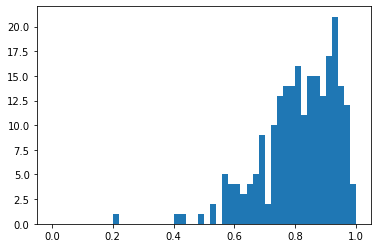

In [66]:
fig = plt.figure()
fig.set_facecolor('white')
bin_count = 50
plt.hist(control_distances_1990, bins=(np.arange(bin_count+1)*(1/bin_count)) )
plt.show()

## To launch many control trials

In [151]:
n_trials = 5
ld_array = np.empty(n_trials)
pvals = np.empty(n_trials)
for seed in range(n_trials):
    control_pairs = list()
    rng = np.random.default_rng(seed)
    for (s1,s2) in tqdm(syn_pairs_avg):
        control_pairs.append( control_search(s1,s2, base=2) )

    control_distances_1890 = []
    control_distances_1990 = []
    for i,(c1,c2, _, _) in tqdm(enumerate(control_pairs), desc="Controls", total=len(control_pairs)):
        ind1 = word2ind[c1]
        ind2 = word2ind[c2]
        v10, v20 = matrix_1890[[ind1,ind2]]
        control_distances_1890.append(JSD( v10 , v20 , base=base))
        v11, v21 = matrix_1990[[ind1,ind2]]
        control_distances_1990.append(JSD( v11 , v21 , base=base))
    control_distances_1890 = np.array(control_distances_1890)
    control_distances_1990 = np.array(control_distances_1990)

    ld_prop = (distances_1990 > control_distances_1990).sum()/len(distances_1990)
    print(f'Law of differentiation: {ld_prop.round(3)*100}% \t Law of parallel change: {(1-ld_prop).round(3)*100}%')
    ld_array[seed] = ld_prop
    
    result_binom_test = stats.binomtest( k =  (distances_1990 > control_distances_1990).sum(), n = len(distances_1990), alternative='greater' )
    print('Test: \tH0: "LPC/LD are even." \tH1: "LD more frequent than LPC."')
    print(f'p-value:\t {result_binom_test.pvalue}\nCI of LD:\t{result_binom_test.proportion_ci()}')
    pvals[seed] = result_binom_test.pvalue

Controls: 100%|██████████| 1357/1357 [00:00<00:00, 1522.39it/s]


Law of differentiation: 76.4% 	 Law of parallel change: 23.599999999999998%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 9.309424846803458e-89
CI of LD:	ConfidenceInterval(low=0.7444471499543046, high=1.0)


Controls: 100%|██████████| 1357/1357 [00:00<00:00, 1419.42it/s]


Law of differentiation: 76.6% 	 Law of parallel change: 23.400000000000002%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 8.779716848343135e-90
CI of LD:	ConfidenceInterval(low=0.7459596398446993, high=1.0)


Controls: 100%|██████████| 1357/1357 [00:00<00:00, 1419.92it/s]


Law of differentiation: 78.3% 	 Law of parallel change: 21.7%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 4.279673670587881e-102
CI of LD:	ConfidenceInterval(low=0.7633766721842701, high=1.0)


Controls: 100%|██████████| 1357/1357 [00:00<00:00, 1463.73it/s]


Law of differentiation: 78.60000000000001% 	 Law of parallel change: 21.4%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 6.6897476884580344e-105
CI of LD:	ConfidenceInterval(low=0.7671688819367283, high=1.0)


Controls: 100%|██████████| 1357/1357 [00:00<00:00, 1433.25it/s]

Law of differentiation: 76.6% 	 Law of parallel change: 23.400000000000002%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 8.779716848343135e-90
CI of LD:	ConfidenceInterval(low=0.7459596398446993, high=1.0)


In [152]:
ld_prop = ld_array.mean()
pvalue = pvals.mean()
print(f'Law of differentiation: {ld_prop.round(3)*100}% \t Law of parallel change: {(1-ld_prop).round(3)*100}%')
print('Test: \tH0: "LPC/LD are even." \tH1: "LD more frequent than LPC."')
print(f'p-value:\t {pvalue}\n')
    

Law of differentiation: 77.3% 	 Law of parallel change: 22.7%
Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 2.2130736432945024e-89



## New decision rule without controls

In [11]:
less_changed = np.array(semchanges['1990'].argsort())[:100]

In [12]:
n_samples = len(less_changed)**2
lessSC_distances_1890 = np.empty(n_samples)
lessSC_distances_1990 = np.empty(n_samples)
for index in tqdm(range(n_samples)):
    ind1 = less_changed[index // len(less_changed)]
    ind2 = less_changed[index % len(less_changed)]
    v10, v20 = matrix_1890[[ind1,ind2]]
    lessSC_distances_1890[index] = JSD( v10 , v20 , base=base)
    v11, v21 = matrix_1990[[ind1,ind2]]
    lessSC_distances_1990[index] = JSD( v11 , v21 , base=base)

100%|██████████| 10000/10000 [00:08<00:00, 1141.31it/s]


In [102]:
len(distances_1990)

69

In [103]:
div_syns = distances_1990-distances_1890
div_pop = random_distances_1990 - random_distances_1890
div_lessSC = lessSC_distances_1990 - lessSC_distances_1890

In [104]:
len(lessSC_distances_1890)

10000

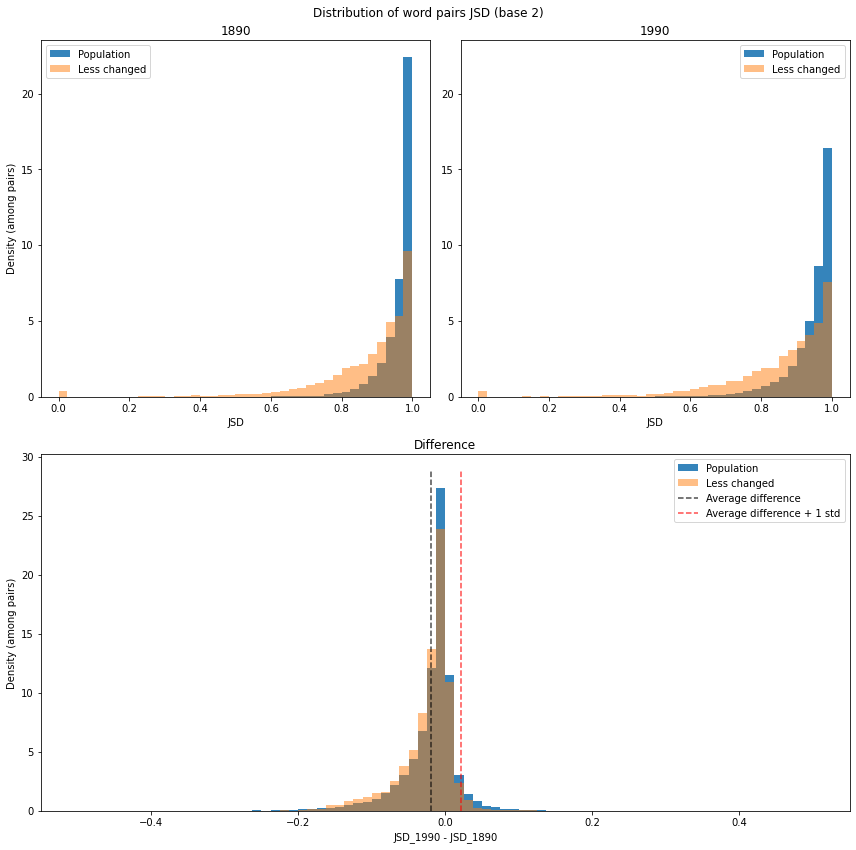

In [105]:
distance_name = f'JSD (base {base})'
bin_count = 40

fig = plt.figure(figsize=(12,12))
fig.set_facecolor('white')
ax = fig.subplot_mosaic([['1890','1990'],['D','D']])
ax['1890'].hist(random_distances_1890, bins=(np.arange(bin_count+1)*(1/bin_count)), label = 'Population', alpha=0.9 , density=True)
ax['1890'].hist(lessSC_distances_1890, bins=(np.arange(bin_count+1)*(1/bin_count)), label = 'Less changed', alpha=0.5, density=True )
ax['1890'].legend()
ax['1890'].set_title('1890')
ax['1990'].hist(random_distances_1990, bins=(np.arange(bin_count+1)*(1/bin_count)), label = 'Population', alpha=0.9, density=True )
ax['1990'].hist(lessSC_distances_1990, bins=(np.arange(bin_count+1)*(1/bin_count)), label = 'Less changed', alpha=0.5, density=True )
ax['1990'].legend()
ax['1990'].set_title('1990')
ax['1990'].set_ylim( ax['1890'].get_ylim() ) 
diff_random = random_distances_1990-random_distances_1890
ax['D'].hist(div_pop, bins=(np.arange(2*bin_count+1)*(0.5/bin_count)-0.5), label = 'Population', alpha=0.9, density=True)
ax['D'].hist(div_lessSC, bins=(np.arange(2*bin_count+1)*(0.5/bin_count)-0.5), label = 'Less changed', alpha=0.5, density=True)
ymin, ymax = ax['D'].get_ylim()
ax['D'].vlines(diff_random.mean(),ymin=ymin, ymax=ymax ,label='Average difference',colors='black',linestyles='--',alpha=0.7)
ax['D'].vlines(diff_random.mean()+diff_random.std(), ymin=ymin, ymax=ymax,label='Average difference + 1 std',colors='red',linestyles='--',alpha = 0.7)
ax['D'].set_title('Difference')
ax['D'].legend()
ax['1890'].set_ylabel('Density (among pairs)')
ax['1890'].set_xlabel('JSD')
ax['1990'].set_xlabel('JSD')
ax['D'].set_ylabel('Density (among pairs)')
ax['D'].set_xlabel('JSD_1990 - JSD_1890')
fig.suptitle(f'Distribution of word pairs {distance_name}')
fig.tight_layout()
fig.savefig('./img/'+distance_name+'_lessSC_'+pos+'.png',transparent=False,dpi=100)
plt.show()

In [109]:
threshold = div_pop.mean() + div_lessSC.std()
ld_prop = ( div_syns > threshold ).sum()/len(div_syns)
print(f'Law of differentiation: {ld_prop.round(3)*100}% \t Law of parallel change: {(1-ld_prop).round(3)*100}%')

Law of differentiation: 49.3% 	 Law of parallel change: 50.7%


In [110]:
result_binom_test = stats.binomtest( k =  ( div_syns > threshold ).sum(), n = len(distances_1990), alternative='greater' )
print('Test: \tH0: "LPC/LD are even." \tH1: "LD more frequent than LPC."')
print(f'p-value:\t {result_binom_test.pvalue}\nCI of LD:\t{result_binom_test.proportion_ci()}')

Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.5950254735405376
CI of LD:	ConfidenceInterval(low=0.38829147255322677, high=1.0)


In [111]:
result_binom_test = stats.binomtest( k =  ( div_syns > threshold ).sum(), n = len(distances_1990), alternative='less' )
print('Test: \tH0: "LPC/LD are even." \tH1: "LD less frequent than LPC."')
print(f'p-value:\t {result_binom_test.pvalue}\nCI of LD:\t{result_binom_test.proportion_ci()}')

Test: 	H0: "LPC/LD are even." 	H1: "LD more frequent than LPC."
p-value:	 0.4999999999999999
CI of LD:	ConfidenceInterval(low=0.0, high=0.5976970529130115)


## JSD evolution graphs

In [13]:
syns_D = np.array([distances_1890,distances_1990])
controls_D = np.array([control_distances_1890,control_distances_1990])
pop_D = np.array([random_distances_1890,random_distances_1990])
lessSC_D = np.array([lessSC_distances_1890,lessSC_distances_1990])

if len(distances_1890) != len(control_distances_1890):
    raise ValueError('Syns and controls not matching.')

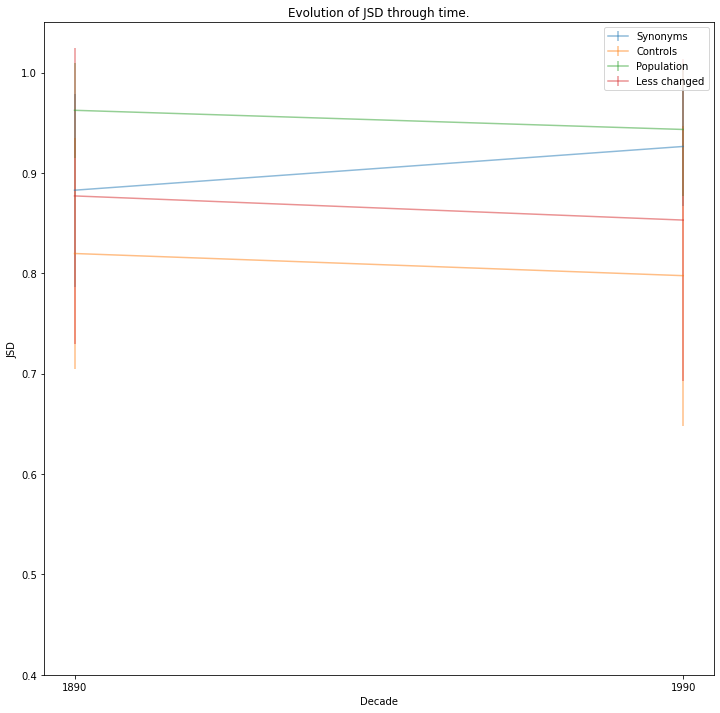

In [15]:
distance_name = 'JSD'

decades_X = [1890,1990]

fig = plt.figure(figsize=(12,12))
fig.set_facecolor('white')
ax = fig.add_subplot(111)


ax.errorbar(x = decades_X, y=syns_D.mean(axis=1), yerr=syns_D.std(axis=1), label='Synonyms', alpha=0.5)
ax.errorbar(x = decades_X, y=controls_D.mean(axis=1), yerr=controls_D.std(axis=1), label='Controls', alpha=0.5)
ax.errorbar(x = decades_X, y=pop_D.mean(axis=1), yerr=pop_D.std(axis=1), label='Population', alpha=0.5)
ax.errorbar(x = decades_X, y=lessSC_D.mean(axis=1), yerr=lessSC_D.std(axis=1), label='Less changed', alpha=0.5)

ax.set_xticks(decades_X)
ax.set_ylim(0.4,1.05)
ax.set_title('Evolution of JSD through time.')
ax.set_xlabel('Decade')
ax.set_ylabel('JSD')
ax.legend()

fig.savefig('./img/'+distance_name+'_evolution_'+pos+'.png',transparent=False,dpi=100)
plt.show()

## Junk

In [ ]:
base = None
ind1,ind2 = np.random.choice(np.arange(matrix_1890.shape[0]),size=2)
print( word_list[ind1],word_list[ind2] )
v10, v20 = matrix_1890[[ind1,ind2]]
d_1890 = JSD( v10 , v20 ,base=base)
v11, v21 = matrix_1990[[ind1,ind2]]
d_1990 = JSD( v11 , v21 , base=base)
print(d_1890.round(2),d_1990.round(2))

artful delicious
0.69 0.68


In [10]:
def _JSD(p,q,base=None):
    m = np.mean([p,q],axis=0)
    if base==None or base==np.e:
        log_func = np.log
    elif base == 2:
        log_func = np.log2 
    elif base == 10:
        log_func = np.log10
    return 0.5*( kl_div(p,m,_log=log_func) + kl_div(q,m,_log=log_func))

def kl_div(p,q,_log = np.log):
    sv = 0
    sc = 0
    for i in range( len(p) ):
        if p[i]==0:
            pass
        elif p[i]>0 and q[i]==0:
            sv += p[i]*_log(p[i])
            sc += -np.inf
        elif p[i]>0 and q[i]>0:
            sv += p[i]*_log(p[i])
            sc += p[i]*_log(q[i])
        else:
            return np.nan
    return sv - sc



In [ ]:
text = ''
for _ in range(10):
    s1,s2 = syn_pairs_avg[np.random.randint(len(syn_pairs_avg))]
    ind1 = word2ind[s1]
    ind2 = word2ind[s2]
    v10, v20 = matrix_1890[[ind1,ind2]]
    d_s = JSD( v10 , v20 )
    sc_s = semchanges.loc[s1]['1990'] + semchanges.loc[s2]['1990']
    text += f'Synonyms : ({s1} , {s2}) \t d={d_s.round(3)}\t SC={sc_s}\nControls: \n'
    for pair in [control_search_naive(s1,s2) for _ in range(10)]:
        c1, c2, d_c, sc_c = pair
        text += f'({c1} , {c2}) \t d={d_c} \t SC={sc_c}\n'
    text += '\n'
with open('controls_sample_naive.txt','w',encoding='utf-8') as f:
    f.write(text)